In [1]:
import os
from flarepy_DS_Tuc_A import FlareDetector
import plotly.express as px
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from numpy.polynomial import Polynomial
import flarepy_EK_Dra as EK_Dra
import flarepy_DS_Tuc_A as DS_Tuc
import flarepy_V889_Her as V889
import matplotlib.pyplot as plt

In [2]:
try:
    import flarepy_EK_Dra as ek_module
    import flarepy_V889_Her as v889_module
    import flarepy_DS_Tuc_A as ds_module
    # 他の星のモジュールも同様に追加
except ImportError as e:
    print(f"Error importing analyzer modules: {e}")
    print("Make sure the analyzer Python files (e.g., analyzer_EK_Dra.py) are in the correct path.")
    exit()

# 2. 星の名前と、使用するFlareDetectorクラスをマッピングする辞書
#    キー: 星のフォルダ名 (os.listdir(base_stars_folder) で取得される名前と一致させる)
#    値: 対応するモジュール内の FlareDetector クラス
STAR_CLASS_MAP = {
    "EKDra": ek_module.FlareDetector,
    "V889 Her": v889_module.FlareDetector,
    "DS Tuc A": ds_module.FlareDetector,
    # 他の星も同様に追加: "StarFolderName": corresponding_module.FlareDetector
}

# 3. 星のデータが格納されている親フォルダ
BASE_STARS_FOLDER = "C:/Users/81803/Documents/フレア/Kyoto_Student_Flare_Project/all_stars/" # ご自身の環境に合わせて変更してください

# 4. 全ての星の解析結果を格納する辞書 (星の名前がキー)
all_stars_detectors = {}

# 5. 親フォルダ内の各星フォルダをループ
if not os.path.exists(BASE_STARS_FOLDER):
    print(f"Error: Base stars folder '{BASE_STARS_FOLDER}' not found.")
    exit()

for star_folder_name in os.listdir(BASE_STARS_FOLDER):
    star_folder_path = os.path.join(BASE_STARS_FOLDER, star_folder_name)

    if not os.path.isdir(star_folder_path): # フォルダでなければスキップ
        continue

    # 6. この星に対応する FlareDetector クラスを取得
    if star_folder_name not in STAR_CLASS_MAP:
        print(f"Warning: No FlareDetector class mapped for star folder '{star_folder_name}'. Skipping.")
        continue
    TargetFlareDetectorClass = STAR_CLASS_MAP[star_folder_name]

    print(f"Processing star: {star_folder_name} (using {TargetFlareDetectorClass.__module__}.FlareDetector)")

    # 7. 特定の星のFlareDetectorインスタンスを格納するための辞書
    star_specific_detectors = {}

    # 星フォルダ内のファイルリストにフルパスを格納
    file_list = [os.path.join(star_folder_path, fname) for fname in os.listdir(star_folder_path)]

    for file_path in file_list:
        if not file_path.endswith(".fits"): # FITSファイルのみを対象
            continue

        file_name_only = os.path.basename(file_path)
        s_number = None
        # ファイル名から "s" の後の4桁の数字を抽出 (例: s0001)
        for part in file_name_only.split("-"):
            if part.startswith("s") and len(part) >= 5 and part[1:5].isdigit():
                s_number = part[:5]
                break

        if s_number:
            instance_name = f"detector_{s_number}"
            try:
                # 8. 対応する FlareDetector クラスのインスタンスを作成
                #    引数は各 FlareDetector クラスの __init__ メソッドに合わせてください。
                #    ここでは共通のパラメータセットを仮定していますが、
                #    星ごとやクラスごとに異なるパラメータが必要な場合は、
                #    STAR_CLASS_MAP にパラメータ情報も持たせるなどの工夫が必要です。
                detector_params = {
                    "ene_thres_high": 1e39
                }
                detector = TargetFlareDetectorClass(file=file_path, process_data=True, ene_thres_low=5e33,**detector_params)

                # データが有効かどうかの簡単なチェック
                if detector.tessBJD is not None and len(detector.tessBJD) > 0:
                    star_specific_detectors[instance_name] = detector
                else:
                    print(f"  Warning: No data or empty BJD for {file_path} in star {star_folder_name}")

            except Exception as e:
                print(f"  Error processing file {file_path} for star {star_folder_name}: {e}")
                continue # エラーが発生したファイルはスキップ
        # else:
        #     print(f"  Info: Could not extract s_number from {file_name_only}")


    # 9. 星のインスタンス辞書が空でなければソートして格納
    if star_specific_detectors:
        try:
            sorted_star_detectors = dict(sorted(
                star_specific_detectors.items(),
                key=lambda x: x[1].tessBJD[0] if (x[1].tessBJD is not None and len(x[1].tessBJD) > 0) else float('inf')
            ))
            all_stars_detectors[star_folder_name] = sorted_star_detectors
        except IndexError:
            print(f"  Warning: Could not sort detectors for {star_folder_name} due to missing BJD data in some instances.")
            all_stars_detectors[star_folder_name] = star_specific_detectors # ソートせずに格納
        except Exception as e:
            print(f"  Error during sorting detectors for {star_folder_name}: {e}")
            all_stars_detectors[star_folder_name] = star_specific_detectors # ソートせずに格納

    else:
        print(f"  No valid FITS files processed or no s_number found for star: {star_folder_name}")

# 10. 結果の確認 (例)
print("\n--- Analysis Results ---")
for star_name_key, detectors_for_star_dict in all_stars_detectors.items():
    print(f"\nStar: {star_name_key}")
    if detectors_for_star_dict:
        for det_name, det_instance in detectors_for_star_dict.items():
            num_flares = 0
            if hasattr(det_instance, 'peaktime') and det_instance.peaktime is not None:
                num_flares = len(det_instance.peaktime)
            first_bjd_str = "N/A"
            if hasattr(det_instance, 'tessBJD') and det_instance.tessBJD is not None and len(det_instance.tessBJD) > 0:
                first_bjd_str = f"{det_instance.tessBJD[0]:.4f}"

            print(f"  {det_name}: First BJD = {first_bjd_str}, Number of flares = {num_flares}")
    else:
        print("  No detectors successfully processed for this star.")

Processing star: DS Tuc A (using flarepy_DS_Tuc_A.FlareDetector)
0.0005393407873158274
0.0005725893849369089
0.0006004632364496608
0.0005141985908197649
0.0005279562046814211
Processing star: EKDra (using flarepy_EK_Dra.FlareDetector)
0.0003853715316471647
0.0004326351494269867
0.00040146709420494546
0.0004332178463686818
0.0004152705924634479
0.00036634229017243276
0.0004366249552695763
0.0003500553957392958
0.0004254482712039496
0.0003678562699295867
0.0005562915548140923
0.00036705732936266974
Processing star: V889 Her (using flarepy_V889_Her.FlareDetector)
0.0003247068011459851
0.0002999992076390454
0.0005822159276534688
0.0003801855383152267

--- Analysis Results ---

Star: DS Tuc A
  detector_s0001: First BJD = 1325.2988, Number of flares = 10
  detector_s0027: First BJD = 2036.2815, Number of flares = 13
  detector_s0028: First BJD = 2061.8541, Number of flares = 12
  detector_s0067: First BJD = 3126.6448, Number of flares = 8
  detector_s0068: First BJD = 3154.8702, Number of f

In [4]:
print("\n--- DEBUG INFO: Checking Attributes ---")
if 'all_stars_detectors' in locals() and all_stars_detectors:
    try:
        # 辞書から最初の星の名前を取得
        first_star_name = next(iter(all_stars_detectors))
        first_star_detectors = all_stars_detectors[first_star_name]
        
        if first_star_detectors:
            # その星の最初のインスタンスを取得
            first_instance = next(iter(first_star_detectors.values()))
            print(f"List of attributes for one instance of star '{first_star_name}':")
            
            # インスタンスが持つ全ての属性名と、その中身（最初の50文字）を表示
            for attr in dir(first_instance):
                if not attr.startswith('__'): # 特殊な属性は無視
                    try:
                        value = getattr(first_instance, attr)
                        print(f"  - {attr}: {str(value)[:50]}") # 値を少しだけ表示
                    except Exception:
                        print(f"  - {attr}: (Could not get value)")

    except StopIteration:
        print("Could not find any stars or detectors to debug.")
    except Exception as e:
        print(f"An error occurred during debugging: {e}")
print("--- END DEBUG INFO ---\n")


--- DEBUG INFO: Checking Attributes ---
List of attributes for one instance of star 'DS Tuc A':
  - R_sunstar_ratio: 0.87
  - T_star: 5428
  - a_i: [ 0.02714798  0.06758898 -0.02476271  0.03827323  
  - amPDCSAPflux: [0.9781133  0.9786438  0.9774506  ... 0.9845172  0
  - amPDCSAPfluxerr: [0.00038245 0.0003826  0.00038241 ... 0.00038312 0
  - apply_gap_correction: <bound method FlareDetector.apply_gap_correction o
  - array_amplitude: [0.05573314 0.08120024 0.0632453  0.04163897 0.053
  - array_data_name: ['tess2018206045859-s0001' 'tess2020186164531-s002
  - array_energy_ave: []
  - array_energy_ratio: [2.49744365e+33 7.64957441e+33 7.12852744e+33 4.65
  - array_flare_ratio: [0.15080185 0.29996029 0.42253898 0.18802307 0.230
  - array_observation_time: [1338.1120237  2047.94839629 2072.52695069 3140.60
  - array_per: [2.85168517 3.63366337 3.52585259 3.01340134 2.860
  - array_per_err: [0.159966   0.57090709 0.22927293 0.13826383 0.151
  - array_starspot: [1.70449896e+17 2.48336479e+1


Plot saved as 'analysis_result_plot.pdf'


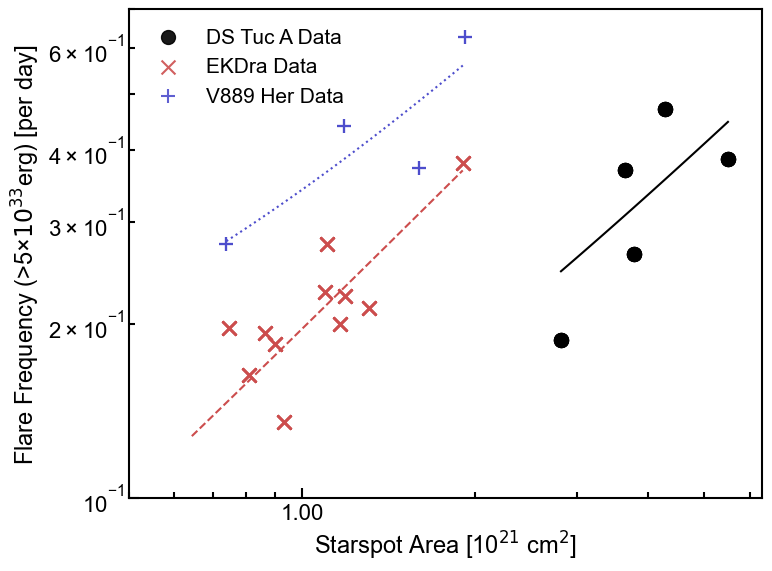

In [11]:
import matplotlib.ticker as mticker

# --- 論文用のスタイル設定 ---
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.size'] = 7
plt.rcParams['ytick.major.size'] = 7
plt.rcParams["xtick.minor.visible"] = True
plt.rcParams["ytick.minor.visible"] = True
plt.rcParams['xtick.minor.width'] = 1.5
plt.rcParams['ytick.minor.width'] = 1.5
plt.rcParams['xtick.minor.size'] = 4
plt.rcParams['ytick.minor.size'] = 4
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.size'] = 16

# --- ここからグラフ作成処理 ---

x_axis_attribute = 'array_starspot'
y_axis_attribute = 'array_flare_ratio'

fig, ax = plt.subplots(figsize=(8, 6))
plot_successful = False

if 'all_stars_detectors' in locals() and all_stars_detectors:
    color_map = {'DS Tuc A': 'black',
        'EKDra': (0.8, 0.3, 0.3), # 例: 彩度を抑えた赤
        'V889 Her': (0.3, 0.3, 0.8) # 例: 彩度を抑えた青
        }
    marker_map = {'DS Tuc A': 'o', 'EKDra': 'x', 'V889 Her': '+'}
    marker_size = 100
    linestyle_map = {'DS Tuc A': '-', 'EKDra': '--', 'V889 Her': ':'}

    for i, (star_name, detectors_dict) in enumerate(all_stars_detectors.items()):
        # ... (データ収集・スケーリング部分は変更なし) ...
        current_color = color_map.get(star_name, 'grey')
        current_marker = marker_map.get(star_name, 'x')
        current_linestyle = linestyle_map.get(star_name, '-')
        x_data_for_star = []
        y_data_for_star = []

        for det_instance in detectors_dict.values():
            if hasattr(det_instance, x_axis_attribute) and hasattr(det_instance, y_axis_attribute):
                x_array = getattr(det_instance, x_axis_attribute)
                y_array = getattr(det_instance, y_axis_attribute)
                if isinstance(x_array, (list, np.ndarray)) and isinstance(y_array, (list, np.ndarray)) and len(x_array) == len(y_array):
                    x_data_for_star.extend(x_array)
                    y_data_for_star.extend(y_array)

        if len(x_data_for_star) > 1:
            x_data = np.array(x_data_for_star)
            y_data = np.array(y_data_for_star)
            x_data_scaled = x_data / 1e17
            
            ax.scatter(x_data_scaled, y_data, label=f'{star_name} Data', color=current_color, alpha=0.9, marker=current_marker, s=marker_size)
            
            try:
                coeffs = np.polyfit(x_data_scaled, y_data, 1)
                poly = np.poly1d(coeffs)
                x_fit = np.linspace(x_data_scaled.min(), x_data_scaled.max(), 100)
                y_fit = poly(x_fit)

                # ★★★ 1. 凡例から傾きの表示を削除 ★★★
                ax.plot(x_fit, y_fit, color=current_color, linestyle=current_linestyle,
                        #label=f'{star_name} Fit'
                        )
                plot_successful = True
            except Exception as e:
                print(f"Could not perform linear fit for {star_name}: {e}")
    
    if plot_successful:
        ax.set_xlabel(r"Starspot Area [10$^{21}$ cm$^2$]", fontsize=17)
        ax.set_ylabel("Flare Frequency (>5×$10^{33}$erg) [per day]", fontsize=17)

        # ★追加: X軸の範囲を設定
        ax.set_xlim(0.5, 6.3) # 例: X軸を 0 から 10 の範囲に設定
        # ★追加: Y軸の範囲を設定
        ax.set_ylim(0.1, 0.7) # 例: Y軸を 0 から 60 の範囲に設定
        
        # ★★★ 2. 軸をログスケールに変更（必要に応じてコメントを外す） ★★★
        ax.set_yscale('log')
        ax.set_xscale('log')

        # ★ 2. X軸の主目盛りの表示形式を通常の数値に変更 ★
        ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
        # X軸の補助目盛りが指数表示になるのを防ぐ（任意）
        ax.xaxis.set_minor_formatter(mticker.NullFormatter())

        # ax.legend() の引数に frameon=False を追加するだけ
        ax.legend(loc='upper left',fontsize=15, frameon=False)
        ax.tick_params(axis='both', which='major', labelsize=16)
        #ax.grid(True)
        fig.tight_layout()
        plt.savefig('analysis_result_plot.pdf', format='pdf', bbox_inches='tight')
        print("\nPlot saved as 'analysis_result_plot.pdf'")
        plt.show()
    else:
        print("\nNo data was plotted.")
else:
    print("\nError: 'all_stars_detectors' dictionary not found or is empty.")


Processing class: flarepy_EK_Dra.FlareDetector (for star key: 'EKDra')
  Found 'array_starspot': [8.62477197e+16 1.16437695e+17 6.44053637e+16 1.90328699e+17
 1.30958303e+17 7.47423509e+16 1.10754407e+17 9.29591505e+16
 8.08395396e+16 8.97733121e+16 1.09753527e+17 1.18687506e+17]
  Found 'array_flare_ratio': [0.19309531 0.20032363 0.08559108 0.37980074 0.21328289 0.19696682
 0.27484351 0.13542152 0.16347618 0.1848408  0.22703499 0.22348529]

Processing class: flarepy_V889_Her.FlareDetector (for star key: 'V889 Her')
  Found 'array_starspot': [1.92341414e+17 1.18150552e+17 1.60019961e+17 7.39477496e+16]
  Found 'array_flare_ratio': [0.62651495 0.44007891 0.3714661  0.27474633]

Processing class: flarepy_DS_Tuc_A.FlareDetector (for star key: 'DS Tuc A')
  Found 'array_starspot': [1.70449896e+17 2.48336479e+17 1.93424475e+17 1.27345375e+17
 1.64333695e+17]
  Found 'array_flare_ratio': [0.15080185 0.29996029 0.42253898 0.18802307 0.23025421]


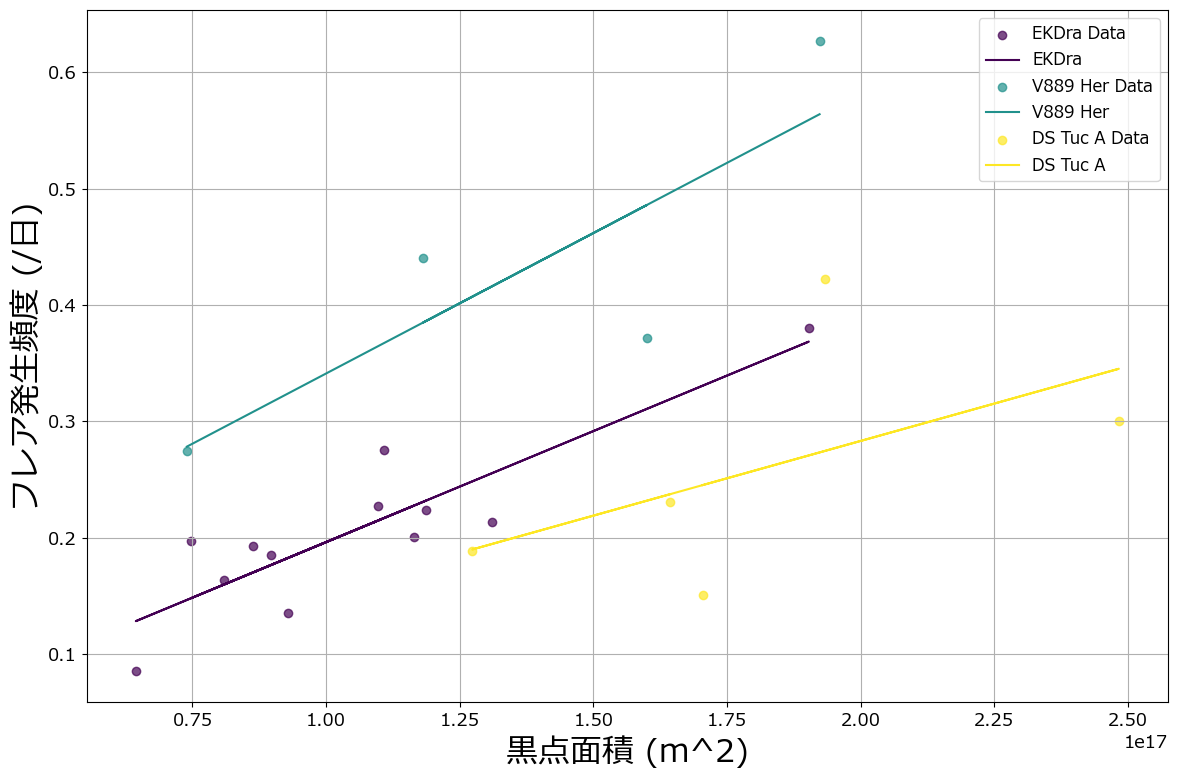

In [6]:
plt.rcParams['font.family'] = 'Meiryo'
# 例：macOSの場合
# plt.rcParams['font.family'] = 'Hiragino Sans'

# フォントサイズもここでまとめて設定可能
plt.rcParams['font.size'] = 14
plt.rcParams['axes.labelsize'] = 23  # 軸ラベル
plt.rcParams['xtick.labelsize'] = 13 # x軸の目盛り
plt.rcParams['ytick.labelsize'] = 13 # y軸の目盛り
plt.rcParams['legend.fontsize'] = 12 # 凡例
plt.rcParams['figure.titlesize'] = 30# タイトル



array_rot_period = [0.2094793179536128,
                    0.2094793179536128,
                    0.2094793179536128,
                    0.2094793179536128,
                    0.2094793179536128,
                    0.2094793179536128,
                    0.2094793179536128,
                    0.2094793179536128,
                    0.2094793179536128,
                    0.2094793179536128,
                    0.2094793179536128,
                    0.2094793179536128,
                    0.2094793179536128,
                    0.2094793179536128,
                    ]

class_var_name_x = 'array_starspot'         # ★ X軸に対応するクラス変数名
class_var_name_y = 'array_flare_ratio'   # ★ Y軸に対応するクラス変数名

plt.figure(figsize=(12, 8))
plot_successful = False

colors = plt.cm.viridis(np.linspace(0, 1, len(STAR_CLASS_MAP))) # 各クラスに異なる色を割り当て


for i, (star_key_in_map, TargetDetectorClass) in enumerate(STAR_CLASS_MAP.items()):
    print(f"\nProcessing class: {TargetDetectorClass.__module__}.{TargetDetectorClass.__name__} (for star key: '{star_key_in_map}')")

    # 2つのクラス変数がクラスに存在するか確認
    if hasattr(TargetDetectorClass, class_var_name_x) and \
       hasattr(TargetDetectorClass, class_var_name_y):

        class_var_x_values = getattr(TargetDetectorClass, class_var_name_x)
        class_var_y_values = getattr(TargetDetectorClass, class_var_name_y)

        print(f"  Found '{class_var_name_x}': {class_var_x_values}")
        print(f"  Found '{class_var_name_y}': {class_var_y_values}")

        # 値がプロット可能な数値配列であり、長さが同じであることを確認
        is_x_valid = isinstance(class_var_x_values, (list, tuple, np.ndarray)) and \
                     all(isinstance(item, (int, float, np.number)) for item in class_var_x_values)
        is_y_valid = isinstance(class_var_y_values, (list, tuple, np.ndarray)) and \
                     all(isinstance(item, (int, float, np.number)) for item in class_var_y_values)

        if is_x_valid and is_y_valid:
            # NumPy配列に変換
            x_data = np.array(class_var_x_values)
            y_data = np.array(class_var_y_values)

            if len(x_data) == len(y_data) and len(x_data) > 1: # データ点が2つ以上必要
                # 散布図をプロット
                plt.scatter(x_data, y_data, label=f'{star_key_in_map} Data', color=colors[i], alpha=0.7)

                # 線形フィッティング (y = mx + c)
                # deg=1 は線形フィットを意味する
                try:
                    coeffs = np.polyfit(x_data, y_data, 1) # [傾き m, 切片 c]
                    poly = np.poly1d(coeffs)
                    y_fit = poly(x_data)

                    # フィッティング直線をプロット
                    plt.plot(x_data, y_fit, color=colors[i], linestyle='-',
                             label=f'{star_key_in_map}')
                    #print(f"  Fit for {star_key_in_map}: slope={coeffs[0]:.2f}, intercept={coeffs[1]:.2f}")
                    plot_successful = True

                except np.linalg.LinAlgError:
                    print(f"  Could not perform linear fit for {star_key_in_map} (LinAlgError). Skipping fit line.")
                except Exception as e:
                    print(f"  Error during fitting for {star_key_in_map}: {e}. Skipping fit line.")

            elif len(x_data) != len(y_data):
                print(f"  Class variables '{class_var_name_x}' and '{class_var_name_y}' have different lengths. Skipping plot for {star_key_in_map}.")
            else: # len(x_data) <= 1
                 print(f"  Not enough data points (<=1) for fitting for {star_key_in_map}. Skipping plot.")
        else:
            print(f"  One or both class variables are not lists/tuples/arrays of numbers for {star_key_in_map}.")
    else:
        missing_vars = []
        if not hasattr(TargetDetectorClass, class_var_name_x):
            missing_vars.append(class_var_name_x)
        if not hasattr(TargetDetectorClass, class_var_name_y):
            missing_vars.append(class_var_name_y)
        print(f"  Class variable(s) '{', '.join(missing_vars)}' not found in {TargetDetectorClass.__name__}. Skipping this class.")

if plot_successful:
    # フォントサイズを指定 (数値はお好みで調整してください)
    label_fontsize = 23
    title_fontsize = 30
    legend_fontsize = 12
    tick_fontsize = 13  # 目盛りラベルのフォントサイズ

    plt.xlabel(f"黒点面積 (m^2)", fontsize=label_fontsize)
    plt.ylabel(f"フレア発生頻度 (/日)", fontsize=label_fontsize)
    #plt.title(f"Fig.4  Starspot Area vs Flare Frequency ", fontsize=title_fontsize)
    plt.legend(fontsize=legend_fontsize)

    # X軸とY軸の目盛りラベルのフォントサイズも設定できます
    plt.xticks(fontsize=tick_fontsize)
    plt.yticks(fontsize=tick_fontsize)

    plt.grid(True)
    plt.tight_layout() # ラベルが重ならないように調整
    plt.show()
else:
    print(f"\nNo plots were generated. Ensure '{class_var_name_x}' and '{class_var_name_y}' are valid class variables "
          f"containing arrays of numbers of the same length in the mapped FlareDetector classes.")


Processing class: flarepy_EK_Dra.FlareDetector (for star key: 'EKDra')
  Found 'array_starspot_ratio': [0.0321148  0.04335621 0.02398169 0.07086992 0.04876303 0.02783072
 0.04124    0.03461384 0.03010104 0.03342758 0.04086732 0.04419394]
  Found 'array_flare_ratio': [0.19309531 0.20032363 0.08559108 0.37980074 0.21328289 0.19696682
 0.27484351 0.13542152 0.16347618 0.1848408  0.22703499 0.22348529]
  Fit for EKDra (log-log): y = C*x^m, m=1.05, C=6.00e+00

Processing class: flarepy_V889_Her.FlareDetector (for star key: 'V889 Her')
  Found 'array_starspot_ratio': [0.06328287 0.0388731  0.05264869 0.02432979]
  Found 'array_flare_ratio': [0.62651495 0.44007891 0.3714661  0.27474633]
  Fit for V889 Her (log-log): y = C*x^m, m=0.70, C=3.72e+00

Processing class: flarepy_DS_Tuc_A.FlareDetector (for star key: 'DS Tuc A')
  Found 'array_starspot_ratio': [0.07409205 0.1079482  0.08407876 0.05535515 0.07143343]
  Found 'array_flare_ratio': [0.15080185 0.29996029 0.42253898 0.18802307 0.23025421

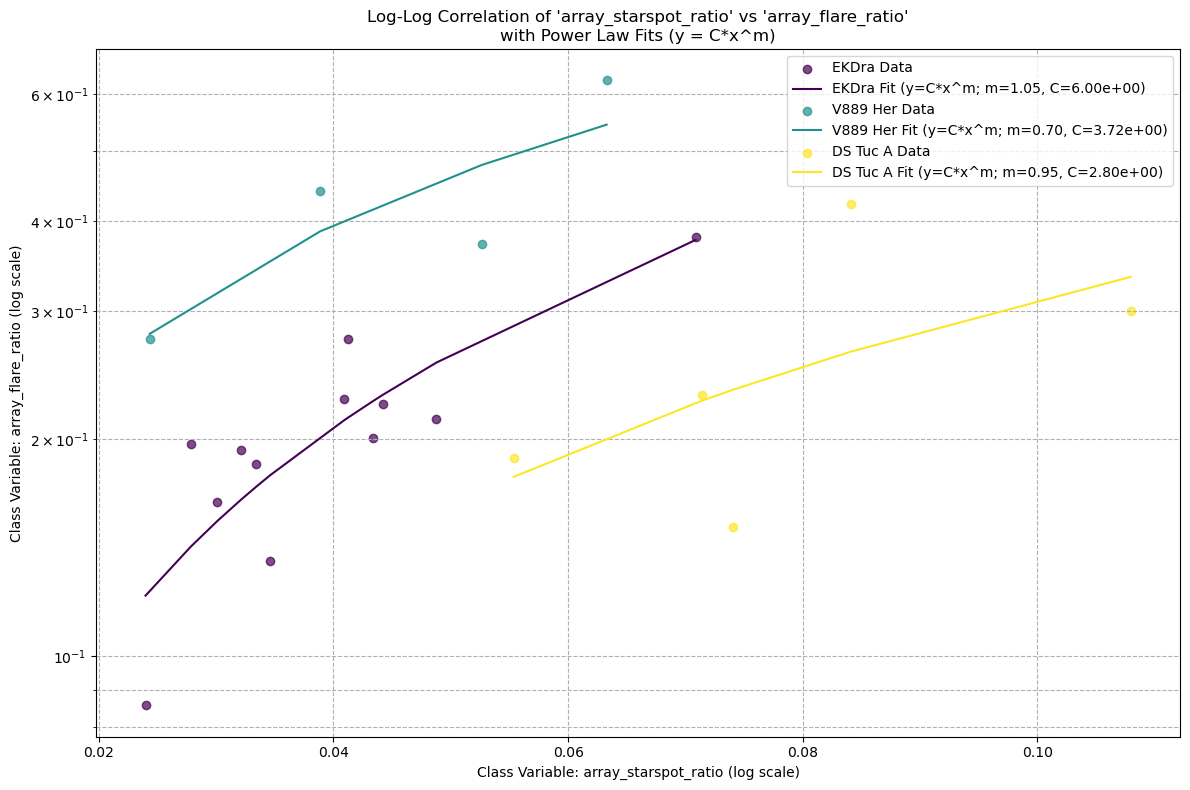

In [4]:
class_var_name_x = 'array_starspot_ratio'         # ★ X軸に対応するクラス変数名
class_var_name_y = 'array_flare_ratio'   # ★ Y軸に対応するクラス変数名

plt.figure(figsize=(12, 8))
plot_successful = False

colors = plt.cm.viridis(np.linspace(0, 1, len(STAR_CLASS_MAP))) # 各クラスに異なる色を割り当て

for i, (star_key_in_map, TargetDetectorClass) in enumerate(STAR_CLASS_MAP.items()):
    print(f"\nProcessing class: {TargetDetectorClass.__module__}.{TargetDetectorClass.__name__} (for star key: '{star_key_in_map}')")

    # 2つのクラス変数がクラスに存在するか確認
    if hasattr(TargetDetectorClass, class_var_name_x) and \
       hasattr(TargetDetectorClass, class_var_name_y):

        class_var_x_values = getattr(TargetDetectorClass, class_var_name_x)
        class_var_y_values = getattr(TargetDetectorClass, class_var_name_y)

        print(f"  Found '{class_var_name_x}': {class_var_x_values}")
        print(f"  Found '{class_var_name_y}': {class_var_y_values}")

        # 値がプロット可能な数値配列であり、長さが同じであることを確認
        is_x_valid = isinstance(class_var_x_values, (list, tuple, np.ndarray)) and \
                     all(isinstance(item, (int, float, np.number)) for item in class_var_x_values)
        is_y_valid = isinstance(class_var_y_values, (list, tuple, np.ndarray)) and \
                     all(isinstance(item, (int, float, np.number)) for item in class_var_y_values)

        if is_x_valid and is_y_valid:
            # NumPy配列に変換
            x_data = np.array(class_var_x_values)
            y_data = np.array(class_var_y_values)

            if len(x_data) == len(y_data) and len(x_data) > 1: # データ点が2つ以上必要
                # 散布図をプロット
                plt.scatter(x_data, y_data, label=f'{star_key_in_map} Data', color=colors[i], alpha=0.7)
                try:
                    # 1. データを対数変換 (log10を使用)
                    log_x_data = np.log10(x_data)
                    log_y_data = np.log10(y_data)

                    # 2. 対数変換したデータで線形フィット
                    # coeffs_log[0] は傾き m, coeffs_log[1] は log10(C)
                    coeffs_log = np.polyfit(log_x_data, log_y_data, 1)
                    m_log = coeffs_log[0]
                    log10_C = coeffs_log[1]

                    # 3. フィット線を元のスケールに戻してプロット (またはlogスケール上で)
                    #    x_data_plot はソートしておくと線が綺麗
                    x_fit_line_sorted = np.sort(x_data)
                    # y = C * x^m  => log10(y) = m * log10(x) + log10(C)
                    # なので、y_fit = 10**(m_log * np.log10(x_fit_line_sorted) + log10_C)
                    y_fit_on_original_scale = 10**(m_log * np.log10(x_fit_line_sorted) + log10_C)

                    plt.plot(x_fit_line_sorted, y_fit_on_original_scale, color=colors[i], linestyle='-',
                             label=f'{star_key_in_map} Fit (y=C*x^m; m={m_log:.2f}, C={10**log10_C:.2e})')
                    print(f"  Fit for {star_key_in_map} (log-log): y = C*x^m, m={m_log:.2f}, C={10**log10_C:.2e}")
                    plot_successful = True

                except np.linalg.LinAlgError:
                    print(f"  Could not perform log-log linear fit for {star_key_in_map} (LinAlgError). Skipping fit line.")
                except ValueError as ve: # np.log10 に0以下の値が入った場合など
                    print(f"  ValueError during log transformation or fit for {star_key_in_map}: {ve}. Skipping fit line.")
                except Exception as e:
                    print(f"  Error during log-log fitting for {star_key_in_map}: {e}. Skipping fit line.")

# ... (ループの後) ...

if plot_successful:
    plt.xscale('linear') # 4. 軸をlogスケールに
    plt.yscale('log') # 4. 軸をlogスケールに

    plt.xlabel(f"Class Variable: {class_var_name_x} (log scale)")
    plt.ylabel(f"Class Variable: {class_var_name_y} (log scale)")
    plt.title(f"Log-Log Correlation of '{class_var_name_x}' vs '{class_var_name_y}'\nwith Power Law Fits (y = C*x^m)")
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.tight_layout()
    plt.show()
else:
    print("No data was successfully plotted or fit.")


c:\Users\81803\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 33258 (\N{CJK UNIFIED IDEOGRAPH-81EA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\81803\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 36578 (\N{CJK UNIFIED IDEOGRAPH-8EE2}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\81803\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21608 (\N{CJK UNIFIED IDEOGRAPH-5468}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\81803\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 26399 (\N{CJK UNIFIED IDEOGRAPH-671F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\81803\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 12392 (\N{HIRAGANA LETTER TO}) missing from font(s) DejaVu Sans.
  fig

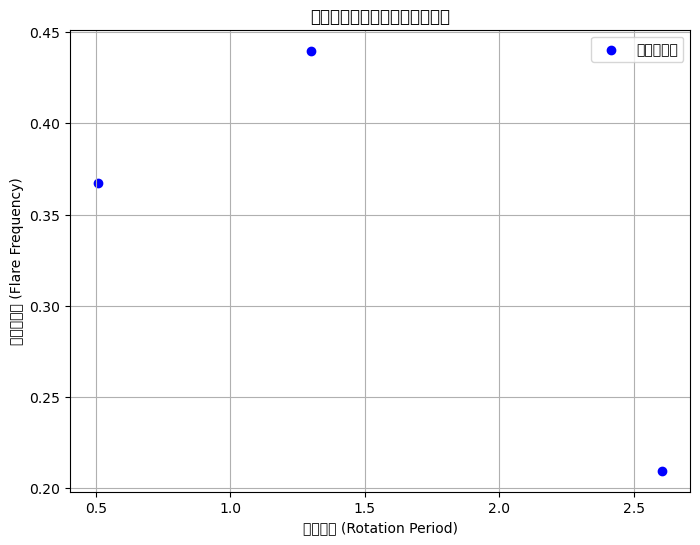

In [5]:
rotation_period_list = [2.605 , 0.51 , 1.3]
flare_frequency_list = [0.2094793179536128 , 0.3672257916463397 , 0.4398277479138892]

# PythonのリストをNumPy配列に変換 (必須ではありませんが、数値計算では一般的です)
rotation_period = np.array(rotation_period_list)
flare_frequency = np.array(flare_frequency_list)

# 散布図の作成
plt.figure(figsize=(8, 6)) # プロットのサイズを指定 (任意)
plt.scatter(rotation_period, flare_frequency, color='blue', marker='o', label='観測データ')

# ラベルとタイトルの設定
plt.xlabel('自転周期 (Rotation Period)')
plt.ylabel('フレア頻度 (Flare Frequency)')
plt.title('自転周期とフレア頻度の散布図')

# グリッドを表示 (任意)
plt.grid(True)

# 凡例を表示 (labelを指定した場合)
plt.legend()

plt.show()